# Churn Model: training and deployment pipeline

The first part of this demo is to train a tabular ML model for predicting churn. This will be used later in the application pipeline to provide context to the LLM to customize the response.

This training pipeline is a standard ML training and deployment pipeline. The only "unusual" step is an additional pre-processing step that generates a sentiment analysis score using historical conversational data from a chat log. This sentiment score is used as a model input - you'll see later that it is actually the most important feature when predicting churn.

In addition to model training, this notebook demonstrates how to log datasets, run ML pipelines remotely, deploy models as serving functions, and enable model monitoring for production use. The workflow is fully automated using MLRun, making it easy to track experiments, manage artifacts, and monitor deployed models in real time.


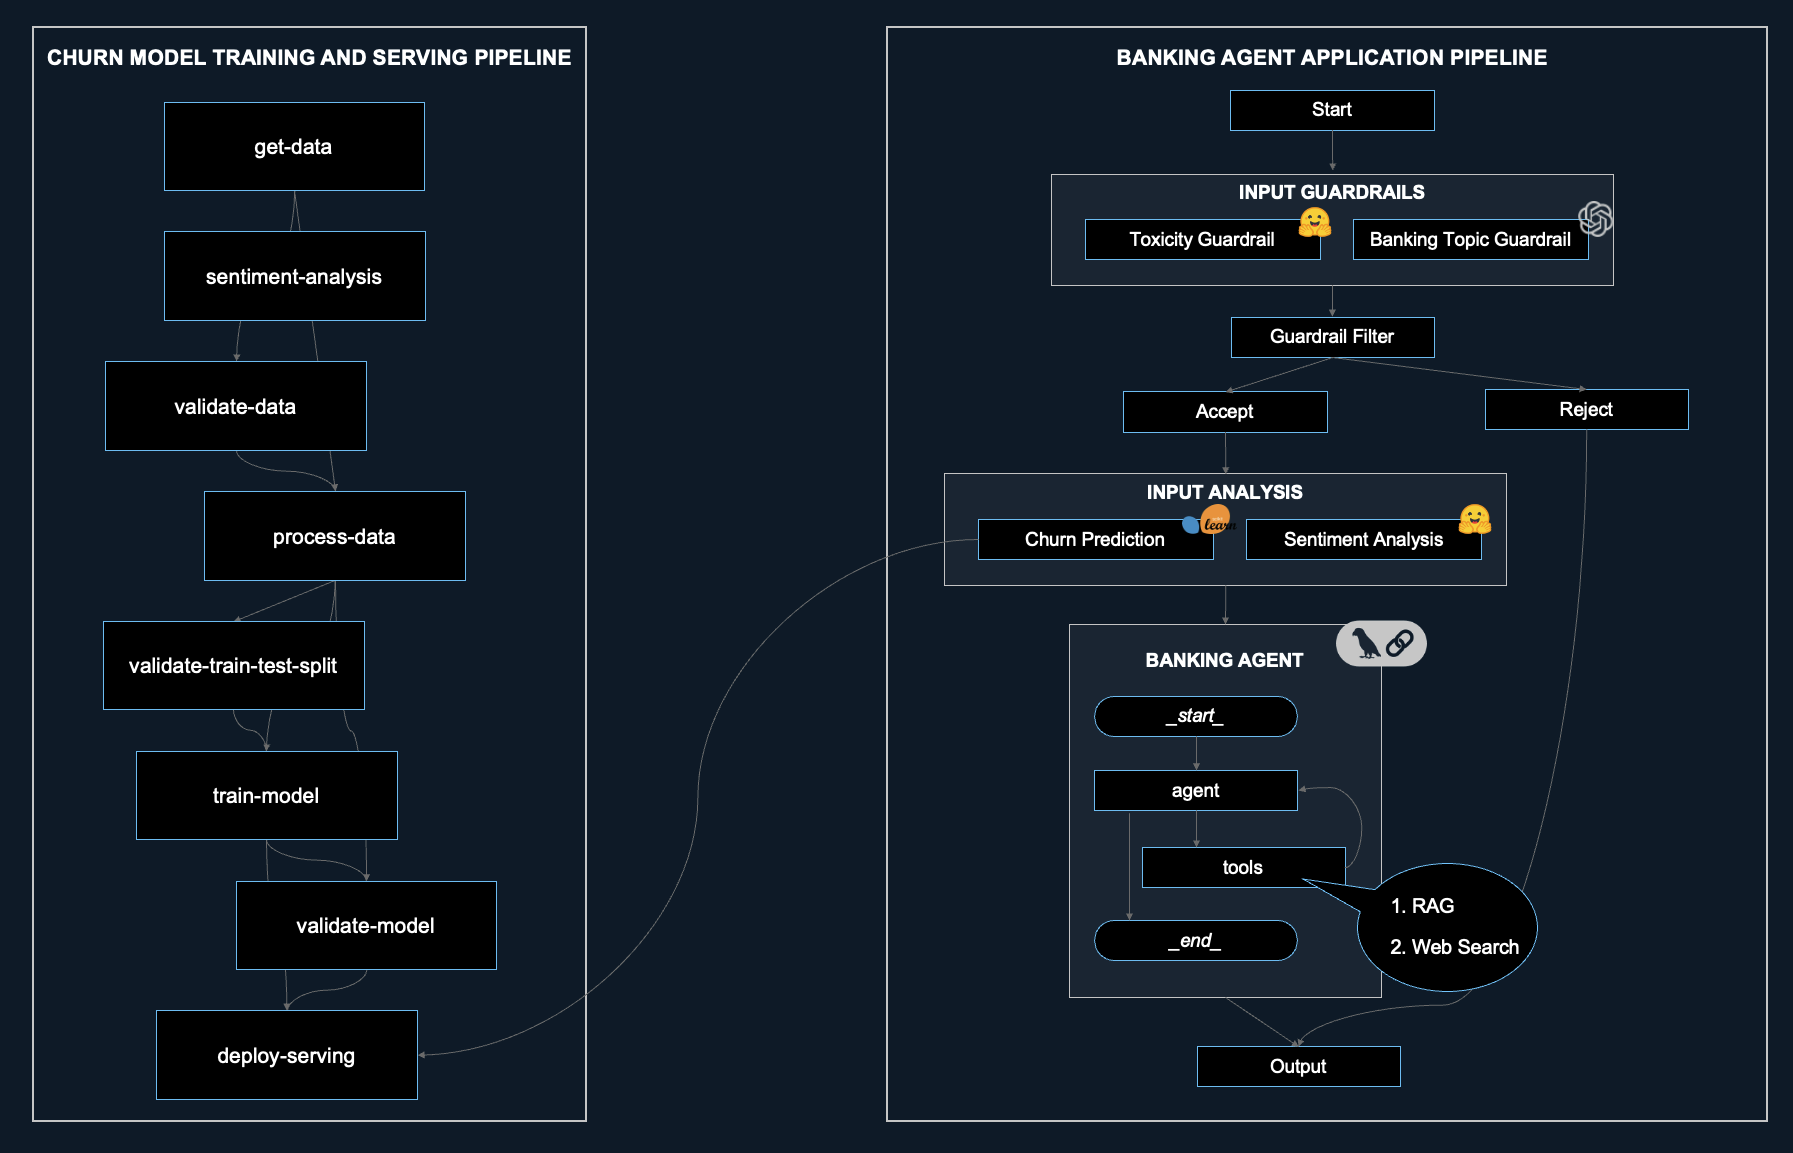
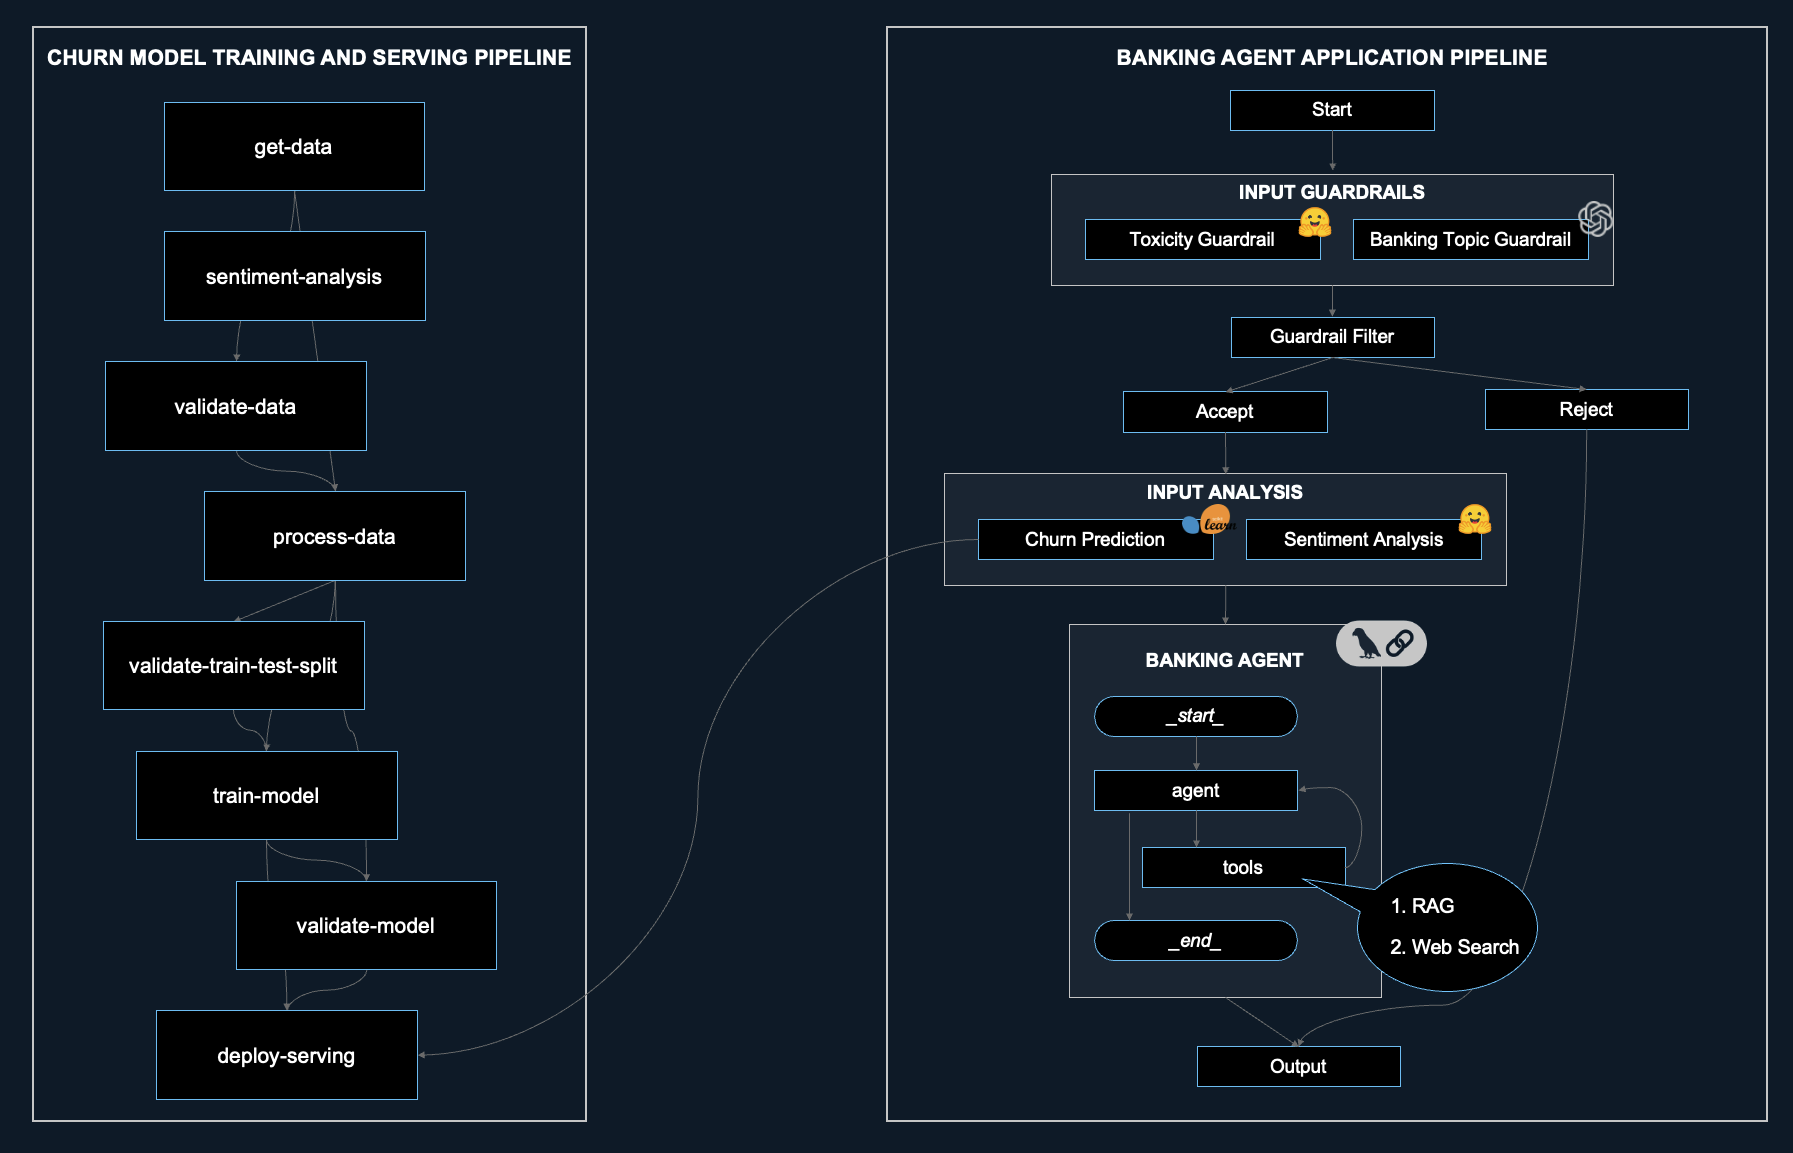
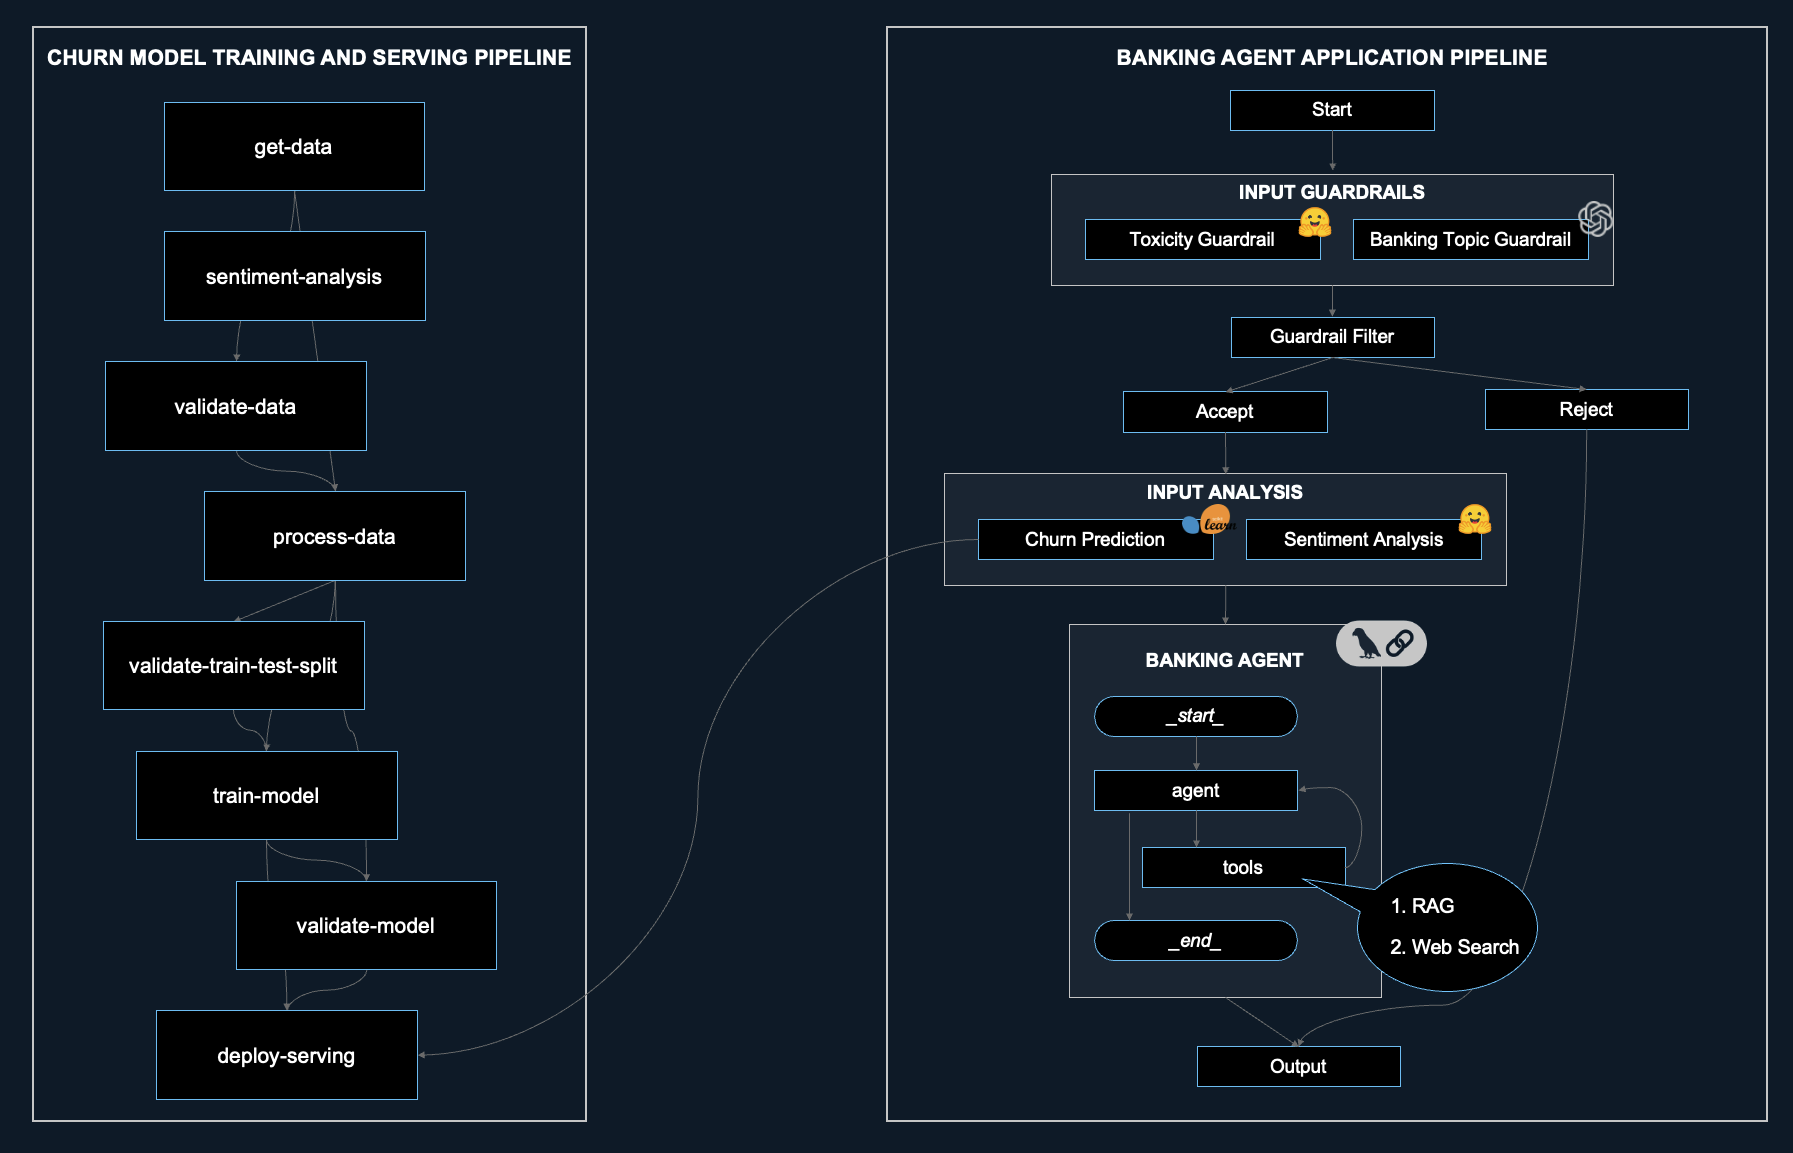

## Table of contents
    1. [Install MLRun](#install-mlrun)
    2. [Set up the project](#set-up-the-project)
    3. [Log the dataset](#log-the-dataset)
    4. [Run the pipeline](#run-the-pipeline)
    5. [View the output training artifacts](#view-the-output-training-artifacts)
    6. [Test the model endpoint](#test-the-model-endpoint)
    7. [Model monitoring](#model-monitoring)
 
 (install-mlrun)=
 ## Install MLRun and set up the environment

 First import mlrun and other required packages:

In [ ]:
%pip install -U -r requirements.txt tqdm

In [ ]:
import mlrun
import pandas as pd
from dotenv import load_dotenv

### Set the up project

Now, create and populate the MLRun project. Under the hood, this executes [project_setup.py](project_setup.py) to add our MLRun functions, workflows, and build the project image. See the [documentation](https://docs.mlrun.org/en/stable/projects/project-setup.html) for more information.

"Make sure to enable `force_build` on the first run to build the project image. This setup ensures all dependencies and source code are packaged for reproducible and scalable ML workflows.  After the initial setup, you can disable `force_build` to speed up subsequent runs.\n",

Set the OpenAI credentials in the project and local environment - **be sure to update [.env.example](.env.example) as described in the [README](README.md#prerequisites)**.

You can run this demo without OpenAI credentials, but be aware that the performance will not be optimal in terms of latency and correctness

##### NOTE: in order to fully use the monitoring feature you have to provide PostgreSQL

In [ ]:
load_dotenv("ai_gateway.env")
mlrun.set_env_from_file("ai_gateway.env")

In [ ]:
project_name = "banking-agent"
project = mlrun.get_or_create_project(
    project_name,
    user_project=True,
    parameters={
        "build_image": True,  # Disable after running once
        "set_functions": True,
    },
)

**Set the `\"build_image\": True` once to build the default image for the project. After you successfully built the image, set the `\"build_image\": False\"` to continue.**

In [ ]:
project.spec.params['build_image']=False
project.save()

Enable project model monitoring on the project and deploy required infrastructure. See [documentation](https://docs.mlrun.org/en/stable/tutorials/05-model-monitoring.html#realtime-monitor-drift-tutor) for more information. This only needs to be run once.

In [ ]:
from src.functions.model_monitoring_utils import enable_model_monitoring

# Enable model monitoring
enable_model_monitoring(project=project, base_period=10, wait_for_deployment=False)

### Log  the dataset

In [ ]:
dataset = project.log_dataset(key="churn", df=pd.read_csv("data/churn_dataset.csv"))
dataset.uri

### Run the pipeline

This step submits the [train_and_deploy_workflow.py](src/workflows/train_and_deploy_workflow.py) via Kubeflow Pipelines. 

This requires a minimum of 6 CPUs to run (see `sentiment_fn` step in train_and_deploy_workflow.py).

In [ ]:
from src.functions.config import MainConfig

arguments = MainConfig(source_url=dataset.uri).model_dump()
arguments

In [ ]:
train_run_id = project.run(
    name="main", engine="remote", arguments=arguments, dirty=True, watch=True, timeout=60*90,
)

### View the output training artifacts

View the training artifacts in the MLRun UI like so:

![](images/churn_pipeline.png)

Alternatively, you can pull the artifacts directly into your notebook for additional exploration like below. See more information about using data and artifacts in the [documentation](https://docs.mlrun.org/en/stable/concepts/data.html).

In [ ]:
serving = project.get_function("serving")

In [ ]:
train_run_id

In [ ]:
workflow_runs = project.list_runs(labels=f"workflow={train_run_id}").to_objects()
workflow_runs = {r.metadata.name: r for r in workflow_runs}
workflow_runs

In [ ]:
workflow_runs["train"].outputs

In [ ]:
workflow_runs["train"].artifact("parallel_coordinates").show()

![](images/training_parallel_coordinates_plot.png)

In [ ]:
workflow_runs["train"].artifact("confusion-matrix").show()

![](images/training_confusion_matrix_plot.png)

In [ ]:
test_set = workflow_runs["train"].artifact("test_set").as_df()
test_set.head()

### Test  the model endpoint

Test the newly deployed real-time endpoint using test data.

In [ ]:
serving_fn = project.get_function("serving")

In [ ]:
data = test_set.drop("churn", axis=1).to_dict(orient="split")["data"]
data[0]

In [ ]:
from random import choice
from time import sleep
from tqdm import tqdm

for i in tqdm(range(1000)):
    data_point = choice(data)
    resp = serving_fn.invoke(
        "/v2/models/churn_model/predict", body={"inputs": [data_point]}
    )
    sleep(choice([0.01, 0.04]))

In [ ]:
%%time
serving_fn.invoke(
    "/v2/models/churn_model/predict",
    body={
        "inputs": data[:10]
    }
)

### Model monitoring

Once the churn model is deployed and invoked, you can view the model monitoring results in the MLRun UI:</br>
![](images/tabular_model_monitoring.png)